# BERT fine-tuning on IMDB video dataset

In [69]:
import json
import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.metrics import classification_report, confusion_matrix
from transformers import TFAutoModelForSequenceClassification
from transformers import BertTokenizer
from transformers import InputExample, InputFeatures
from transformers import pipeline

Test GPU configuration

In [70]:
print("GPU:", tf.config.list_physical_devices("GPU"))

GPU: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## Read data

In [71]:
label2id = {'positive': 1, 'negative': 0}
data = pd.read_csv("data/train.csv") # imdb dataset from kaggle (https://www.kaggle.com/lakshmi25npathi/sentiment-analysis-of-imdb-movie-reviews)

## Define pretrained tokenizer and model

In [72]:
model_name = "bert-base-uncased"
tokenizer = BertTokenizer.from_pretrained(model_name)
model = TFAutoModelForSequenceClassification.from_pretrained(model_name, id2label={v: k for k, v in label2id.items()}, use_cache=False)

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Preprocess data

In [73]:
data['sentiment'] = data['sentiment'].map(label2id)
# data = data.sample(1000) # take only some rows for speeding up train

msk = np.random.rand(len(data)) < 0.8
train = data[msk]
test = data[~msk]

## Create dataset

In [74]:
def convert_data_to_examples(train, test, DATA_COLUMN, LABEL_COLUMN): 
  train_InputExamples = train.apply(lambda x: InputExample(guid=None, # Globally unique ID for bookkeeping, unused in this case
                                                          text_a = x[DATA_COLUMN], 
                                                          text_b = None,
                                                          label = x[LABEL_COLUMN]), axis = 1)

  validation_InputExamples = test.apply(lambda x: InputExample(guid=None, # Globally unique ID for bookkeeping, unused in this case
                                                          text_a = x[DATA_COLUMN], 
                                                          text_b = None,
                                                          label = x[LABEL_COLUMN]), axis = 1)
  
  return train_InputExamples, validation_InputExamples
  
def convert_examples_to_tf_dataset(examples, tokenizer, max_length=128):
    features = [] # -> will hold InputFeatures to be converted later

    for e in examples:
        # Documentation is really strong for this method, so please take a look at it
        input_dict = tokenizer.encode_plus(
            e.text_a,
            add_special_tokens=True,
            max_length=max_length, # truncates if len(s) > max_length
            return_token_type_ids=True,
            return_attention_mask=True,
            pad_to_max_length=True, # pads to the right by default
            truncation=True
        )

        input_ids, token_type_ids, attention_mask = (input_dict["input_ids"],
            input_dict["token_type_ids"], input_dict['attention_mask'])

        features.append(
            InputFeatures(
                input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids, label=e.label
            )
        )

    def gen():
        for f in features:
            yield (
                {
                    "input_ids": f.input_ids,
                    "attention_mask": f.attention_mask,
                    "token_type_ids": f.token_type_ids,
                },
                f.label,
            )

    return tf.data.Dataset.from_generator(
        gen,
        ({"input_ids": tf.int32, "attention_mask": tf.int32, "token_type_ids": tf.int32}, tf.int64),
        (
            {
                "input_ids": tf.TensorShape([None]),
                "attention_mask": tf.TensorShape([None]),
                "token_type_ids": tf.TensorShape([None]),
            },
            tf.TensorShape([]),
        ),
    )

In [75]:
train_InputExamples, validation_InputExamples = convert_data_to_examples(train, test, "review", "sentiment")

train_dataset = convert_examples_to_tf_dataset(list(train_InputExamples), tokenizer)
train_dataset = train_dataset.shuffle(100).batch(32).repeat(2)

validation_dataset = convert_examples_to_tf_dataset(list(validation_InputExamples), tokenizer)
validation_dataset = validation_dataset.batch(32)

/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:2215: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


## Fine-tune pretrained model

In [76]:
optimizer = tf.keras.optimizers.Adam(learning_rate=3e-5, epsilon=1e-08, clipnorm=1.0)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
model.compile(optimizer=optimizer, loss=loss, metrics=[metric])
model.summary()

Model: "tf_bert_for_sequence_classification_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bert (TFBertMainLayer)       multiple                  109482240 
_________________________________________________________________
dropout_189 (Dropout)        multiple                  0         
_________________________________________________________________
classifier (Dense)           multiple                  1538      
Total params: 109,483,778
Trainable params: 109,483,778
Non-trainable params: 0
_________________________________________________________________


## Train model

In [77]:
model.fit(
  train_dataset,
  validation_data=validation_dataset,
  epochs=1,
)


2021-11-14 16:29:51.367771: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


   2502/Unknown - 4557s 2s/step - loss: 0.2424 - accuracy: 0.8982

2021-11-14 17:45:45.002972: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


2502/2502 [==============================] - 4641s 2s/step - loss: 0.2424 - accuracy: 0.8982 - val_loss: 0.3048 - val_accuracy: 0.8868


## Save model

In [78]:
model.save_pretrained("output/model")
tokenizer.save_pretrained("output/model")

# Fix to remove the cache dependencies
tokenizer_config_file = 'output/model/tokenizer_config.json'
with open(tokenizer_config_file, 'r') as f:
  d = json.load(f)
  del d['tokenizer_file']
  f.close()

with open(tokenizer_config_file, 'w') as f:
  json.dump(d, f, indent=2)
  f.close()

## Evaluate the model

In [79]:
sample = data.sample(100)
reviews = sample['review'].to_list()

In [80]:
sample

,review,sentiment
49205,"When I first viewed this movie, I didn't know ...",0
44540,To borrow from Dorothy Parker: This is not a f...,0
44964,This was Charlie Chaplin's first all-talking f...,1
30320,Although the director tried(the filming was ma...,0
45057,"I'm stunt, I must admit I never saw a movie wi...",1
...,...,...
43587,When I first became a father about 5.5 years a...,0
37768,Yet another movie with an interesting premise ...,0
42600,This was a sordid and dreary mess. I needed a ...,0
48043,Comparing Oceans Twelve to the 2001 Oceans Ele...,0


In [81]:
classifier = pipeline('text-classification', model=model, tokenizer=tokenizer)
predictions = classifier(reviews)

y_test = sample['sentiment'].to_list()
y_pred = [label2id[pred['label']] for pred in predictions]

Token indices sequence length is longer than the specified maximum sequence length for this model (1306 > 512). Running this sequence through the model will result in indexing errors


In [82]:
report = classification_report(y_test, y_pred, target_names=label2id.keys(), output_dict=True)
pd.DataFrame(report).T

,precision,recall,f1-score,support
positive,0.955556,0.934783,0.945055,46.00
negative,0.945455,0.962963,0.954128,54.00
accuracy,0.950000,0.950000,0.950000,0.95
macro avg,0.950505,0.948873,0.949592,100.00
weighted avg,0.950101,0.950000,0.949955,100.00


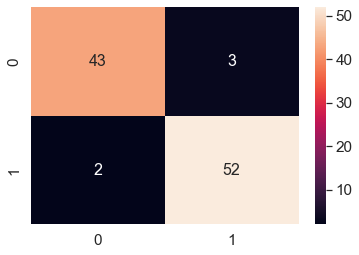

In [83]:
cm = pd.DataFrame(confusion_matrix(y_test, y_pred, labels=range(2)), range(2), range(2))
sn.set(font_scale=1.4) # for label size
sn.heatmap(cm, annot=True, annot_kws={"size": 16}) # font size
plt.show()